# Background removal using Sementic Segmentation Network Unet

In this kernel i am trying to remove the area except the human. for this purpose i have used MHP(multihuman parsing ) dataset. https://lv-mhp.github.io/
I have already merged all the label files and classes into single binary class file which contains only two labels
1 for pixels which contains human | 0 for pixel belongs to background.
Note - Even though no of images present is more than we need, some of image label contain irregularities.
some of the pixel belongs to foreground may labeled as background due to dataset only label human parts and dress making everything else as unknown class.

we are going to start our code with importing required keras and utility packages




In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import matplotlib.pyplot as plt
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout
from tensorflow.python.keras.optimizers import Adadelta, Nadam ,Adam
from tensorflow.python.keras.models import Model, load_model
from tensorflow.python.keras.utils import multi_gpu_model, plot_model ,Sequence
from tensorflow.python.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.python.keras.preprocessing.image import load_img,img_to_array
import tensorflow as tf
from tensorflow.python.keras.losses import binary_crossentropy
from scipy.ndimage import morphology as mp

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("images"))
from glob import glob  # for getting list paths of image and labels
from random import choice,sample
from matplotlib import pyplot as plt
import cv2 # saving and loading images

# Any results you write to the current directory are saved as output.

['Abyssinian_1.jpg', 'Abyssinian_10.jpg', 'Abyssinian_100.jpg', 'Abyssinian_100.mat', 'Abyssinian_101.jpg', 'Abyssinian_101.mat', 'Abyssinian_102.jpg', 'Abyssinian_102.mat', 'Abyssinian_103.jpg', 'Abyssinian_104.jpg', 'Abyssinian_105.jpg', 'Abyssinian_106.jpg', 'Abyssinian_107.jpg', 'Abyssinian_108.jpg', 'Abyssinian_109.jpg', 'Abyssinian_11.jpg', 'Abyssinian_110.jpg', 'Abyssinian_111.jpg', 'Abyssinian_112.jpg', 'Abyssinian_113.jpg', 'Abyssinian_114.jpg', 'Abyssinian_115.jpg', 'Abyssinian_116.jpg', 'Abyssinian_117.jpg', 'Abyssinian_118.jpg', 'Abyssinian_119.jpg', 'Abyssinian_12.jpg', 'Abyssinian_120.jpg', 'Abyssinian_121.jpg', 'Abyssinian_122.jpg', 'Abyssinian_123.jpg', 'Abyssinian_124.jpg', 'Abyssinian_125.jpg', 'Abyssinian_126.jpg', 'Abyssinian_127.jpg', 'Abyssinian_128.jpg', 'Abyssinian_129.jpg', 'Abyssinian_13.jpg', 'Abyssinian_130.jpg', 'Abyssinian_131.jpg', 'Abyssinian_132.jpg', 'Abyssinian_133.jpg', 'Abyssinian_134.jpg', 'Abyssinian_135.jpg', 'Abyssinian_136.jpg', 'Abyssinian_137

# listing image and their respective labels 
also here we are asserting the presence of label file w.r.t each image.

In [4]:
train_img_dir = '/images/'
train_mask_dir = '/masks/'
train_imgs = os.listdir(train_img_dir)
train_masks = os.listdir(train_mask_dir)
print(len(train_imgs))
print(len(train_masks))

FileNotFoundError: [WinError 3] The system cannot find the path specified: '/images/'

In [3]:
train_imgs.sort() # sorting image and label so that they both get alinged on the same index
train_masks.sort()
for i in range(len(train_imgs)):
    assert train_imgs[i] == train_masks[i] , "image and mask are not matching"

**Repeat same steps for validation dataset**

In [4]:
val_img_dir = '/kaggle/input/back-remove/binary_segment/binary_segment/val/images/'
val_mask_dir = '/kaggle/input/back-remove/binary_segment/binary_segment/val/masks/'
val_imgs = os.listdir(val_img_dir)
val_masks = os.listdir(val_mask_dir)
print(len(val_imgs))
print(len(val_masks))

2500
2500


In [5]:
val_imgs.sort()
val_masks.sort()
for i in range(len(val_imgs)):
    assert val_imgs[i].split('.')[0] == val_masks[i].split('.')[0] , "image and mask are not matching"

# Here we impliment keras custom data generator to get batch images and labels without loading whole dataset in the active memory


In [6]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    
    def __init__(self, images,image_dir,labels,label_dir ,batch_size=16, dim=(224,224,3) ,shuffle=True):
        'Initialization'
        self.dim = dim
        self.images = images
        self.image_dir = image_dir
        self.labels = labels
        self.label_dir = label_dir
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [k for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.images))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        batch_imgs = list()
        batch_labels = list()

        # Generate data
        for i in list_IDs_temp:
            # Store sample
            img = load_img(self.image_dir + self.images[i] ,target_size=self.dim)
            img = img_to_array(img)/255.
            batch_imgs.append(img)
           # Store class
            label = load_img(self.label_dir + self.labels[i] ,target_size=self.dim)
            label = img_to_array(label)[:,:,0]
            label = label != 0
            label = mp.binary_erosion(mp.binary_erosion(label))
            label = mp.binary_dilation(mp.binary_dilation(mp.binary_dilation(label)))
            label = np.expand_dims((label)*1 , axis=2)
            batch_labels.append(label)
            
        return np.array(batch_imgs) ,np.array(batch_labels)

 **Now we need to define our training and validation generator using above implimented class.**

In [7]:
train_generator = DataGenerator(train_imgs,train_img_dir,train_masks,train_mask_dir,batch_size=36, dim=(224,224,3) ,shuffle=True)
train_steps = train_generator.__len__()
train_steps

655

**After defining generator lets check the some of the dataset it generates for the training and visualize them**

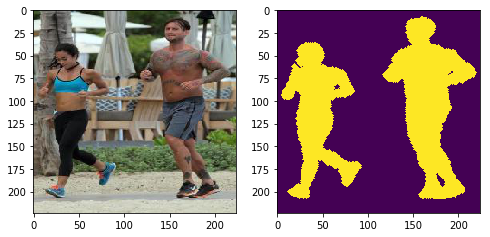

In [8]:
X,y = train_generator.__getitem__(5)
t = 27
plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(X[t])
plt.subplot(122)
plt.imshow(np.reshape(y[t],(224,224)))
#print(np.unique(y[t],return_counts=True))

In [9]:
val_generator = DataGenerator(val_imgs,val_img_dir,val_masks,val_mask_dir,batch_size=36, dim=(224,224,3) ,shuffle=True)
val_steps = val_generator.__len__()
val_steps

69

# After preparing input pipeline we are going to define our U-net model

here we first define down convolution (encoder ) and up convolution layer (decoder) and stack them up with a short circuting features from down sampling to corresponding up sampling

full detail of the  architecture is present here - https://arxiv.org/abs/1505.04597

In [10]:
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y


def Unet(h, w, filters):
# down
    input_layer = Input(shape=(h, w, 3), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = Dropout(0.5)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = Dropout(0.5)(conv5)
# up
    deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6 = Dropout(0.5)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    deconv7 = Dropout(0.5)(deconv7) 
    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)
    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)
    output_layer = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(deconv9)
    # using sigmoid activation for binary classification
    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    return model

In [11]:
model = Unet(224 , 224 , 34)
#model.summary()

# Here we define keras custom metric for the loss and accuracy computation

Jaccard distance loss - this loss help to get rid of the side effects of unbalanced class label in a image (like - 80% background , 20 % human )  https://en.wikipedia.org/wiki/Jaccard_index

dice_coef - To evaluate accuracy of the segmentation.   https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient

In [12]:
def jaccard_distance_loss(y_true, y_pred,smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

# Defining callbacks and compile model with adam optimiser with default learning rate.

In [13]:
model.compile(optimizer='adam', loss=jaccard_distance_loss ,metrics = [dice_coef, 'accuracy'])
mc = ModelCheckpoint(mode='max', filepath='top-weights.h5', monitor='val_dice_coef',save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(mode='max', monitor='val_dice_coef', patience=3, verbose=1)
callbacks = [mc, es]
model.metrics_names

['loss', 'dice_coef', 'acc']

# Now finally train our model with above configuration and train data generator.

In [14]:
results = model.fit_generator(train_generator, steps_per_epoch=train_steps,epochs=8,callbacks=callbacks,validation_data=val_generator,validation_steps=val_steps)

Epoch 1/8
654/655 [============================>.] - ETA: 0s - loss: 4.9903 - dice_coef: 0.8150 - acc: 0.8648
Epoch 00001: val_dice_coef improved from -inf to 0.84581, saving model to top-weights.h5
655/655 [==============================] - 397s 606ms/step - loss: 4.9887 - dice_coef: 0.8151 - acc: 0.8649 - val_loss: 4.4835 - val_dice_coef: 0.8458 - val_acc: 0.8751
Epoch 2/8
654/655 [============================>.] - ETA: 0s - loss: 3.1786 - dice_coef: 0.8803 - acc: 0.9112
Epoch 00002: val_dice_coef improved from 0.84581 to 0.89298, saving model to top-weights.h5
655/655 [==============================] - 356s 543ms/step - loss: 3.1781 - dice_coef: 0.8804 - acc: 0.9112 - val_loss: 3.0902 - val_dice_coef: 0.8930 - val_acc: 0.9136
Epoch 3/8
654/655 [============================>.] - ETA: 0s - loss: 2.6376 - dice_coef: 0.9006 - acc: 0.9262
Epoch 00003: val_dice_coef improved from 0.89298 to 0.89362, saving model to top-weights.h5
655/655 [==============================] - 356s 543ms/step 

** Visualizing train and val loss w.r.t epoch**

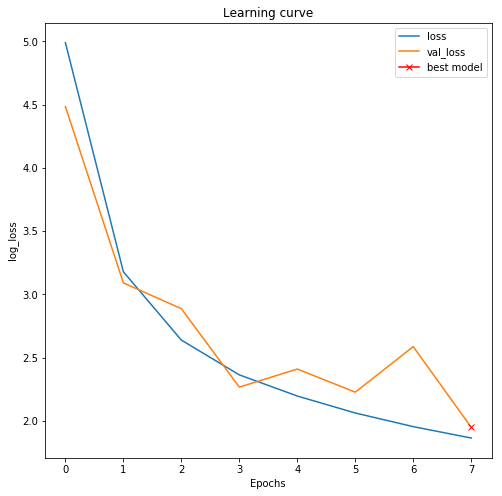

In [15]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [16]:
#model.load_weights('/kaggle/input/background-removal/weights.08-0.97.h5')
#k = model.evaluate_generator(generator=val_generator,steps=val_steps)

# Now its time to make some predictions

In [17]:
test_image = glob('/kaggle/input/test-data/test_images/test_images/*')
#mask_set = glob('/kaggle/input/back-remove/binary_segment/binary_segment/train/masks/1004.jpg')
#len(test_image)

In [18]:
# def jaccard_distance(y_true, y_pred, smooth=100):
#     intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
#     sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
#     jac = (intersection + smooth) / (sum_ - intersection + smooth)
#     return (1 - jac) * smooth

# def jaccard_acc(y_true, y_pred):
#     intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
#     sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
#     jac = intersection / sum_ - intersection
#     return jac

# img = img_to_array(load_img(test_image[0]))
# mask = img_to_array(load_img(mask_set[0]))
# plt.imshow(mask/255.)

# jaccard_distance_loss(mask[:,:,0],mask[:,:,0])

**Function to make prediction 
Note:-  Dont forget to Normalise image dataset (here i divided every pixel by 255. )**

In [19]:
def make_prediction(model,image,shape):
    img = img_to_array(load_img(image,target_size=shape))
    img = np.expand_dims(img,axis=0)/255.
    mask = model.predict(img)
    
    mask = mask[0] > 0.5
    print(np.unique(mask,return_counts=True))
    mask = np.reshape(mask,(224,224))
    return mask                       

(331, 158, 3)

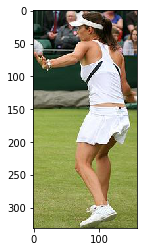

In [20]:
image = test_image[11]
img = img_to_array(load_img(image))
plt.imshow(img/255.)
img.shape

(array([False,  True]), array([31942, 18234]))


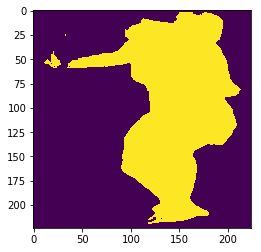

In [21]:
mask = make_prediction(model,image,(224,224,3))
plt.imshow(mask)

**Now use the mask to get the segmented image**

In [22]:
h,w = img.shape[:2]
mask_resized = cv2.resize(np.uint8(mask*1),(w,h))
mask_resized = mask_resized != 0
#print(np.unique(mask_resized,return_counts=True))
segment = np.zeros((h,w,3))
segment[:,:,0] = img[:,:,0]*mask_resized
segment[:,:,1] = img[:,:,1]*mask_resized
segment[:,:,2] = img[:,:,2]*mask_resized
segment[np.where((segment == [0,0,0]).all(axis=2))] = [0,0,0]
#img[np.where((img==[255,255,255]).all(axis=2))] = [0,0,0];

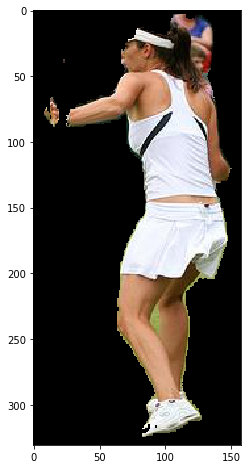

In [23]:
plt.figure(figsize=(8,8))
plt.imshow(segment/255.)